DATA
----
The data is found in the data directory.
It has two files train-images-idx3-ubyte (for image data) and train-images-idx3-ubyte (for labels)
The data needs some processing to be displayed as images.

In [21]:
#load all dependencies
import os
import struct
import numpy as np
from matplotlib import pyplot
import matplotlib as mpl
import random
import tensorflow as tf




In [22]:
"""
Loosely inspired by http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
which is GPL licensed.
"""

def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in xrange(len(lbl)):
        yield get_img(i)

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

60000
3
(28, 28)


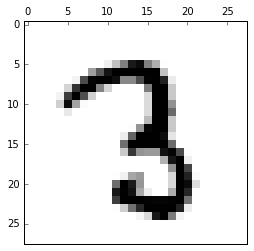

In [23]:

#show a random image
%matplotlib inline
training_data = list(read('training', './data'))
testing_data = list(read('training', './data'))
print(len(training_data))
label, pixels = training_data[random.randint(0,len(training_data))]
print (label)
print (pixels.shape)
show(pixels)

Let's generate a new dataset which has multiple characters(2-5). Each generated image will be of 5x length(blank images are stitched where number of characters is less than 5.

In [24]:
def generateAMultiCharImage(length = -1):
    if length == -1:
        length = random.randint(2,5)
    final_label = []
    final_pixels = np.zeros((28, 5 * 28))
    for i in xrange(length):
        label, pixels = training_data[random.randint(0,len(training_data) - 1)]
        final_pixels[:, i*28:(i+1)*28] = pixels
        final_label.append(label)
    final_pixels = np.reshape(final_pixels, (28, 28 * 5, 1))
    label_one_hot = []
    label_one_hot.append([0] * 6)
    print(len(label_one_hot))
    label_one_hot[0][len(final_label)] = 1
    i = 1
    for num in final_label:
        label_one_hot.append([0] * 10)
        label_one_hot[i][final_label[i - 1]] = 1
        i += 1
    
    
    return {"image" : final_pixels, "label" : label_one_hot, "num_arr" : final_label }

def getBatchData(size = 100):
    batch = {"data" : [], "labels" : []}
    for i in xrange(100):
        data = generateAMultiCharImage()
        batch["data"].append(data["image"])
        label = [0] * 10
        label[data["label"][0]] = 1
        batch["labels"].append(label)
    return batch

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])
        
# a = getBatchData()
a = generateAMultiCharImage()
print(a["label"])
print(a["num_arr"])
# print(len(a["data"][0]))

1
[[0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]
[8, 7]


In [48]:
batch_size = 100
patch_size = 5
depth = 16
num_hidden = 100
image_height = 28
image_width = 5 * 28
num_channels = 1
num_labels = 10
graph = tf.Graph()
valid_data = getBatchData(500)
valid_dataset = np.array(valid_data["data"], dtype=np.float32)
valid_labels = np.array(valid_data["labels"], dtype=np.float32)

test_data = getBatchData(500)
test_dataset = np.array(test_data["data"], dtype=np.float32)
test_labels = np.array(test_data["labels"], dtype=np.float32)

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_width, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_height // 4 * image_width // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    after_max_pool_1 = tf.nn.max_pool(hidden, [1,2,2,1], [1,2,2,1], padding='SAME')
    conv = tf.nn.conv2d(after_max_pool_1, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    after_max_pool_2 = tf.nn.max_pool(hidden, [1,2,2,1], [1,2,2,1], padding='SAME')
    shape = after_max_pool_2.get_shape().as_list()
    reshape = tf.reshape(after_max_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [49]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    batch = getBatchData() 
    batch_data = np.array(batch["data"], dtype=np.float32)
    batch_labels = np.array(batch["labels"], dtype=np.float32)
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 50 == 0):
      print(predictions[0])
      print(batch_labels[0])
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
[  1.82536586e-29   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Minibatch loss at step 0: 289.575867
Minibatch accuracy: 7.0%
Validation accuracy: 12.0%
[ 0.07146059  0.1149429   0.05076832  0.01476169  0.30117899  0.05261385
  0.17597687  0.04895129  0.06980719  0.09953839]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
Minibatch loss at step 50: 2.569883
Minibatch accuracy: 10.0%
Validation accuracy: 18.0%
[ 0.03774406  0.11738942  0.00376146  0.00889116  0.37869039  0.0026386
  0.00236103  0.03876303  0.39229757  0.01746329]
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
Minibatch loss at step 100: 2.197364
Minibatch accuracy: 18.0%
Validation accuracy: 19.0%
[ 0.08222095  0.05045635  0.07668228  0.0967178   0.08562696  0.09750345
  0.31848747  0.07102865  0.06741363  0.05386246]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Minibatch 